# Exercise 1 

In this exercise, we will practice applying a GAN using the `FASHION_MNIST` dataset.

### Exercise 1(a) (5 points)

Load the below libraries and the `FASHION_MNIST` dataset.

```
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(11)
tf.random.set_seed(11)
randomDim = 10
batch_size = 256
max_epochs = 10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(11)
tf.random.set_seed(11)
randomDim = 10
batch_size = 256
max_epochs = 10

### Exercise 1(b) (5 points)

Load the `MNIST` data, and visualize the first 10 images from the `train` and `test` data sets.

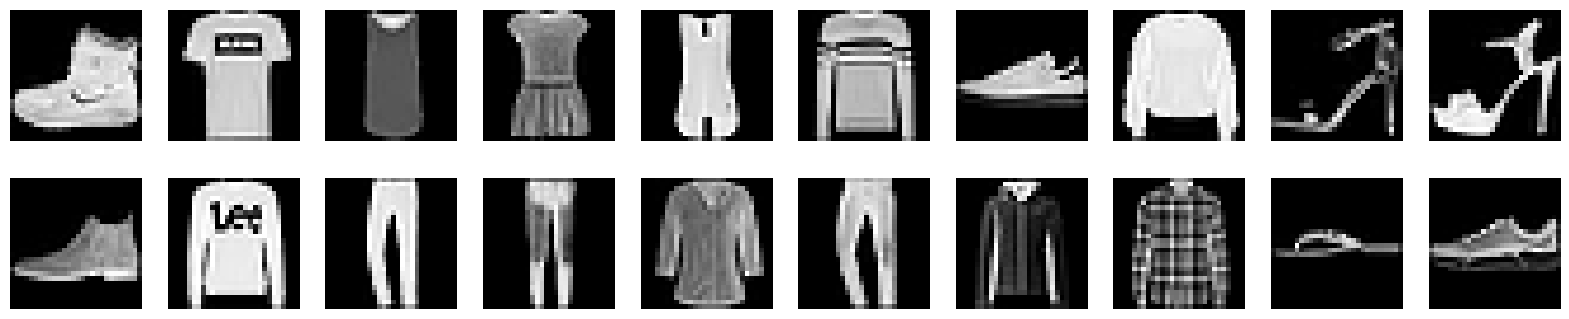

In [2]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

n = 10 
plt.figure(figsize=(20, 8))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, n, i+1+n)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

### Exercise 1(c) (3 points)

Normalize the data to -1 to 1. Then, reshape the data.

In [3]:
# normalize input data to -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# reshape data
X_train = X_train.reshape(60000, 784)

### Exercise 1(d) (10 points)

Define the vanilla GAN presented in the book.

In [5]:
# Optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

# descriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

dLosses = []
gLosses = []

In [6]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

### Exercise 1(e) (10 points)

Train the GAN model.

In [7]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 5 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 10
Batch size: 256
Batches per epoch: 234
--------------- Epoch 1 ---------------
4/4 [==============================] - 0s 5ms/step
--------------- Epoch 2 ---------------
8/8 [==============================] - 0s 3ms/step
--------------- Epoch 3 ---------------
8/8 [==============================] - 0s 3ms/step
--------------- Epoch 4 ---------------
8/8 [==============================] - 0s 4ms/step
--------------- Epoch 5 ---------------
4/4 [==============================] - 0s 3ms/step
--------------- Epoch 6 ---------------
8/8 [==============================] - 0s 3ms/step
--------------- Epoch 7 ---------------
8/8 [==============================] - 0s 3ms/step
--------------- Epoch 8 ---------------
8/8 [==============================] - 0s 3ms/step
--------------- Epoch 9 ---------------
8/8 [==============================] - 0s 4ms/step
--------------- Epoch 10 ---------------
4/4 [==============================] - 0s 3ms/step


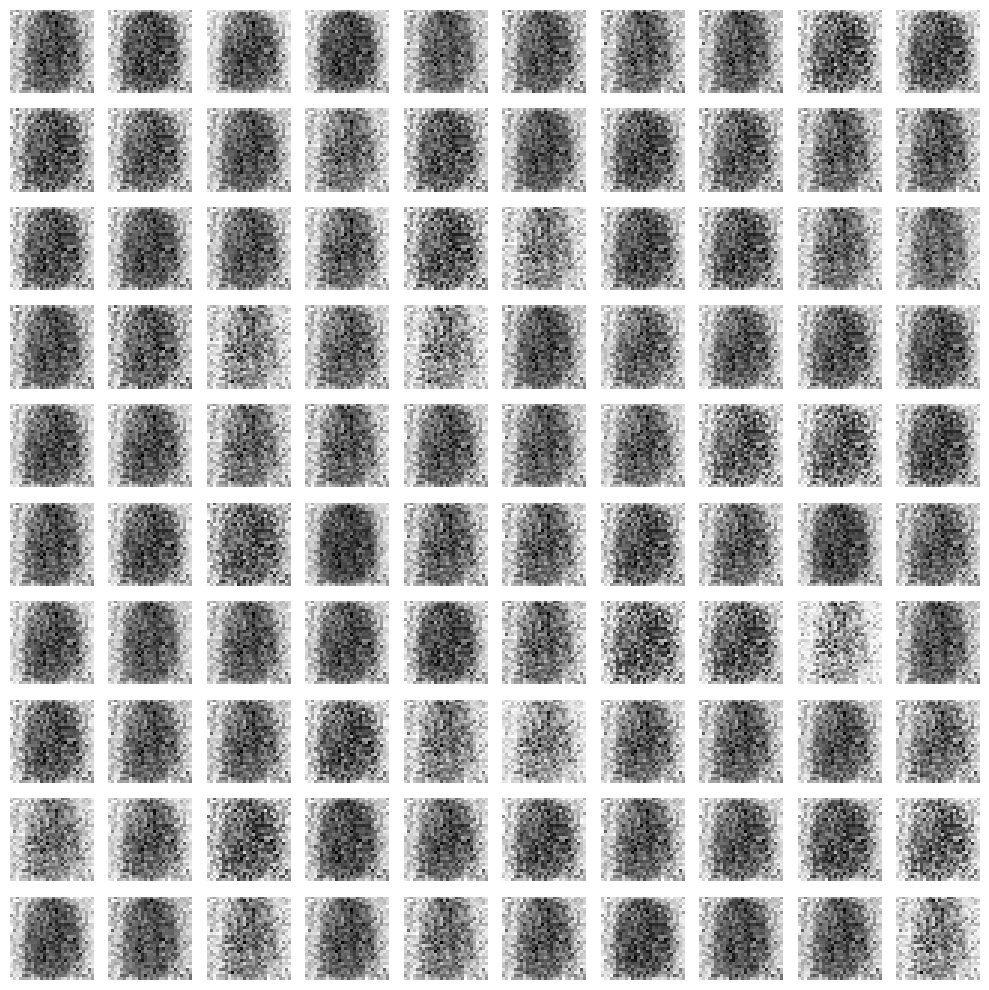

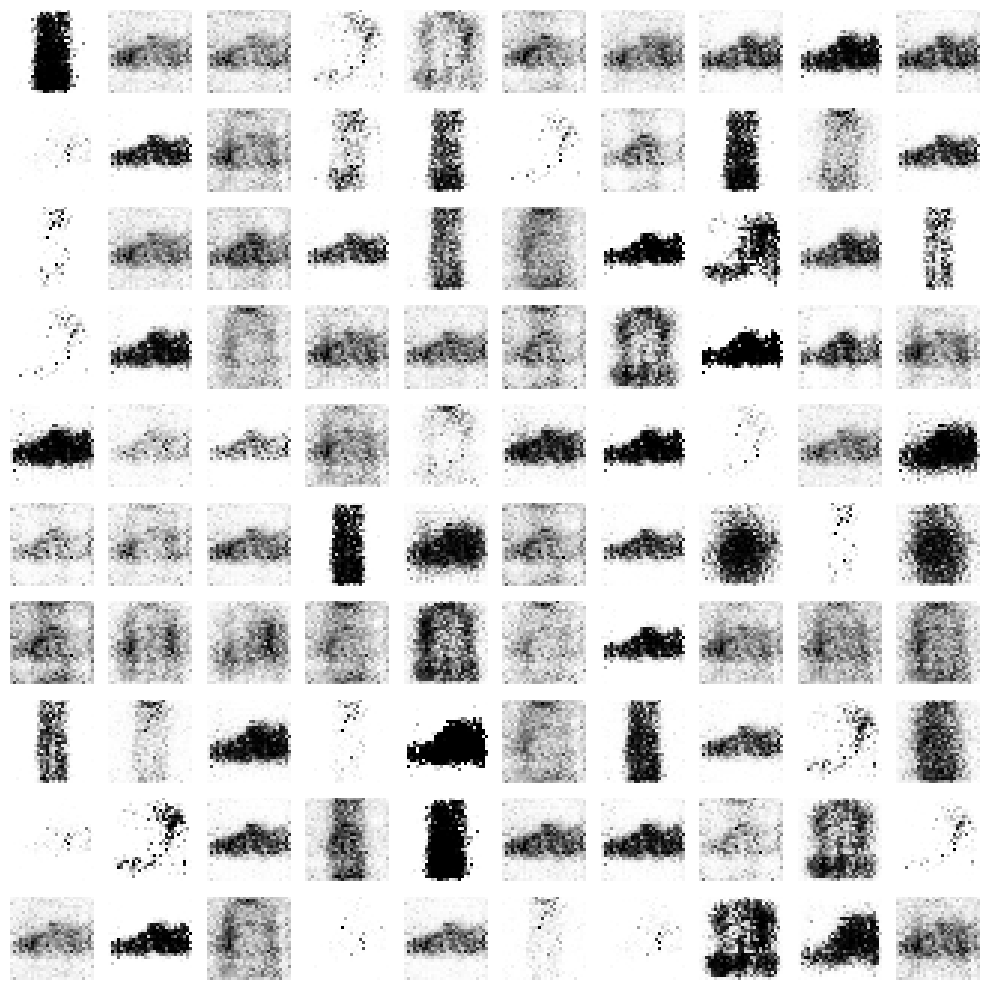

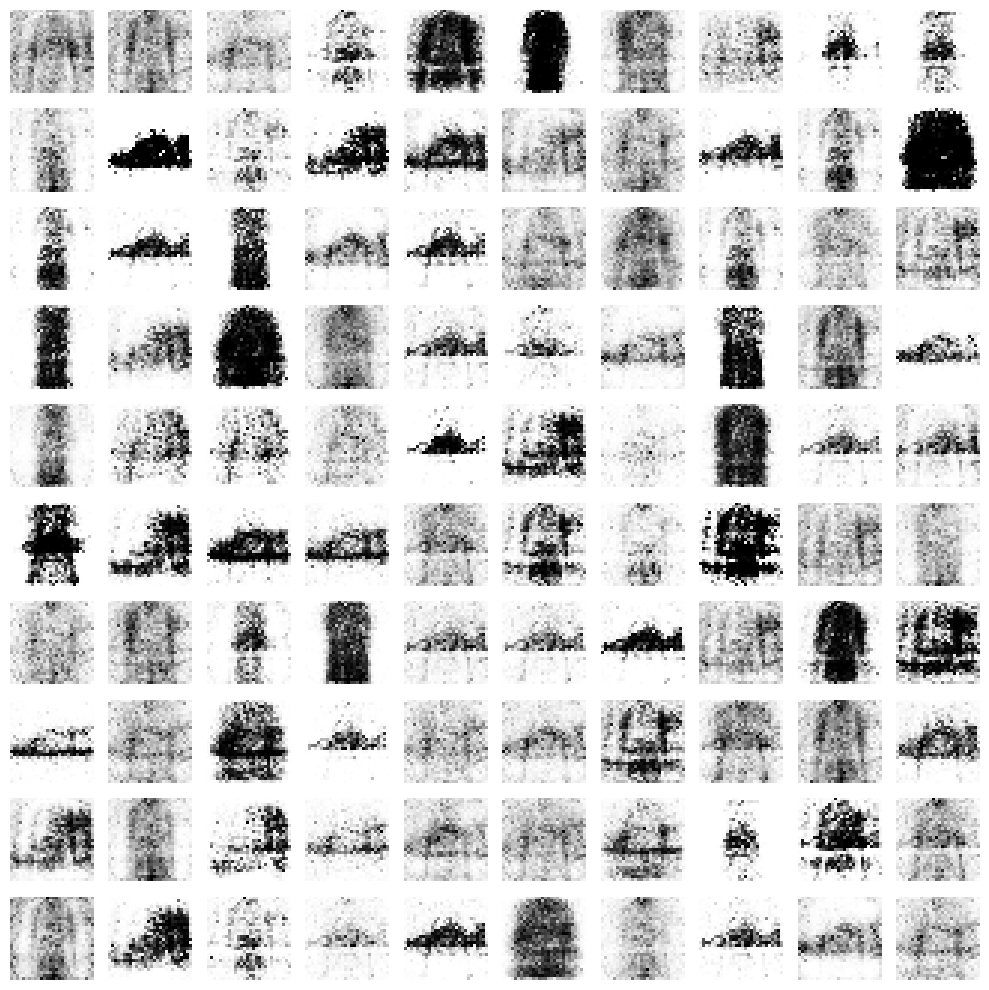

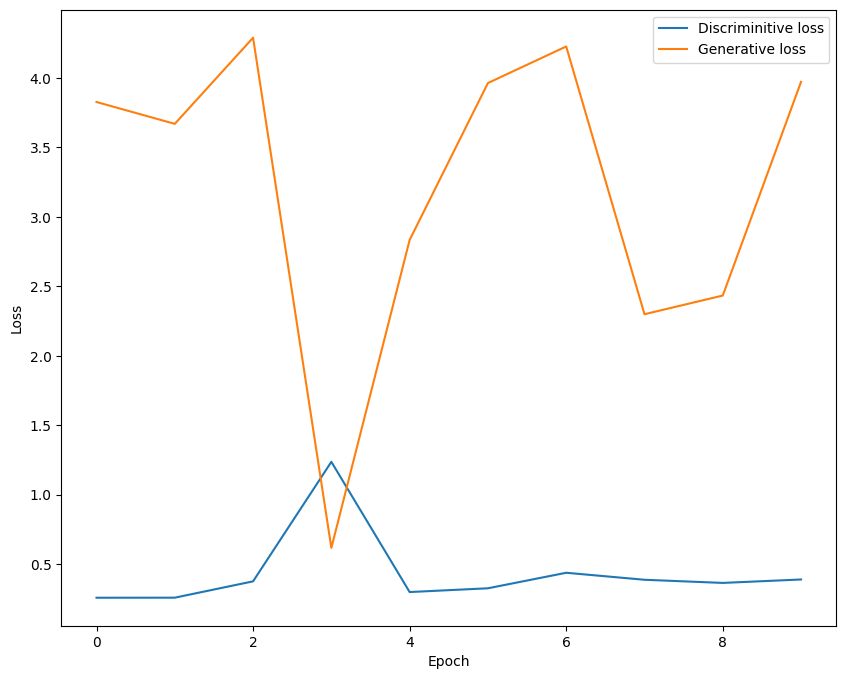

In [8]:
train(max_epochs, batch_size)